# Deep Q-learning and its application for stock trading

## Produced by:
- Anton Chumakov
- Clement Garancini
- Jesse Giroux

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# Import libraries
from IPython.display import SVG, display
import numpy as np
import random
import pandas as pd
from abc import abstractmethod
from typing import Tuple, Dict
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express
colors = plotly.express.colors.qualitative.Plotly # Plotly base colors

import torch
import torch.nn as nn
import torch.optim as optim

# Introduction

Reinforcement learning (RL) is a fast-growing area of research within the field of machine learning, focused on solving sequential decision-making problems. RL algorithms incorporate intelligent agents that learn through interaction with their environments. The feedback an agent receives after interactions with its environment is called the reward. Reward is then used by the agent to measure how well it performs during the learning process. Through trial and error, an agent would ideally be able to learn the interactions with its environment, given its state, that yield the highest possible rewards. This mapping between the state of the environment and what the agent thinks is the best interaction is called the policy and is the solution to any RL problem.

In this tutorial, we will explain a specific algorithm used to solve RL problems, called deep Q-learning. Deep Q-learning is based on estimating the long-term consequences of specific interactions and using those estimations in the decision-making process. To visualize the concepts in action as they are explained, an RL problem will be solved in parallel through the tutorial. The RL problem that will be solved is stock trading. To introduce the building blocks of deep Q-Learning progressively and intuitively, the stock trading problem will be defined and solved in three parts of increasing complexity.

## Generate the stock trading data

In [3]:
def fetch_and_save_stock_data(stock_symbol: str, start_date, end_date, file_name):
    """
    Fetch data from yf database and store it in the current repository.
    Once it is done, the data can be accessed using pd.read_csv(filename)
    """
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    stock_data = preprocess_data(stock_data)
    stock_data.to_csv(file_name)
    print(f"Data for {stock_symbol} saved to {file_name}")


def preprocess_data(df: pd.DataFrame):
    """
    Preprocess the data for our experiments
    """
    df.replace(0, np.nan, inplace=True)

    # Forward and backward fill to handle NaNs
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    return df

# Example usage
fetch_and_save_stock_data("PEP", "2010-01-01", "2023-01-01", "pepsi_data.csv")
fetch_and_save_stock_data("KO", "2010-01-01", "2023-01-01", "cola_data.csv")

[*********************100%%**********************]  1 of 1 completed
Data for PEP saved to pepsi_data.csv
[*********************100%%**********************]  1 of 1 completed
Data for KO saved to cola_data.csv


# Part 1. **Simplified discrete** stock trading problem
---
---

In this first part of the tutorial, the stock trading problem will be solved in its simplest possible form, and as a discrete problem. This first problem will allow us to go over two necessary precursor concepts to Deep Q-learning. Those two concepts are the Markov Decision Process (MDP) and Q-Learning, which will be explained in sections 1.1 and 1.2, respectively. The simplified discrete stock trading problem will be defined in section 1.3, and solved in section 1.4 with the Q-Learning algorithm. Section 1.5 will be reserved to analyze the solution found to the RL problem.

## 1.1 Markov Decision Process (MDP)

---

An MDP is a specific formalization of an RL problem, that provides a framework to solve it through a variety of algorithms, like Q-learning. The key components of an MDP are the states, the actions, and the rewards. The sequential decision-making process that defines an RL problem is represented by a set of dynamic interactions between the agent and the environment using these three components. These dynamic interactions are represented below in their simplest form.

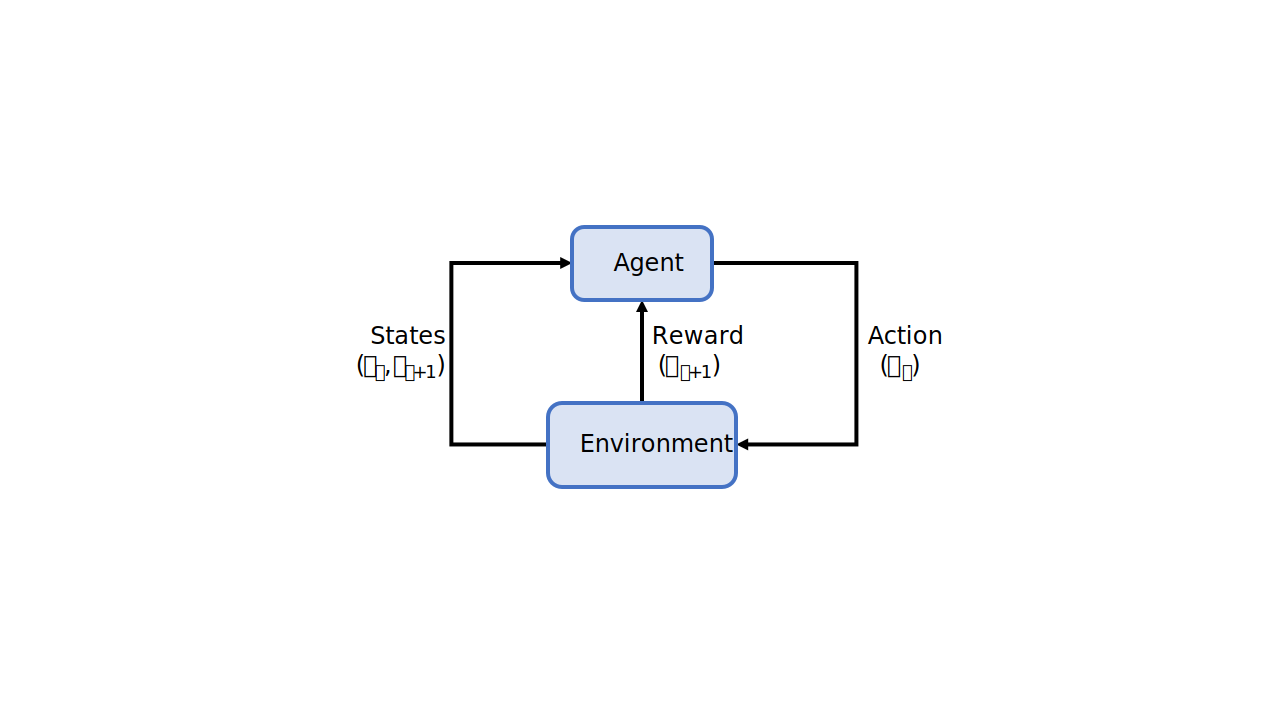

In [4]:
display(SVG(url="https://drive.google.com/uc?id=1mCABJz1dF9VSZEBVltP10iyF_knQ9g7R"))

### States ($S_{t}$, $S_{t+1}$)

The state is a collection of information about the environment at a given time. It can be thought of as a picture of the environment, that the environment itself sends to the agent. This picture contains all relevant information about the environment at a specific time, that the agent would need to make a decision. This idea is important, as it is one of the main hypotheses of an MDP. An MDP supposes that the environment is entirely observable, meaning all the information the agent needs to make a decision is contained within the state. Another important hypothesis of MDPs is that the future is independent of the past, given the present. This means that the environment's future state depends only on the current state and the current action taken. It does not depend on any of the previous states and actions. This concept will become important when the agent tries to learn the best action to take for the state that it receives and will be presented in section 1.2 when we introduce the Q-learning algorithm.

The state of the environment at timestep $t$ is expressed as $S_{t}$. In the diagram above, it's shown that both $S_{t}$ and $S_{t+1}$ are given to the agent by the environment for it to make a decision. This will be explained in section 1.2, as it's important in the context of solving an MDP with the Q-learning algorithm.

### Actions ($A_{t}$)

The actions are the decisions the agent makes upon receiving the environment's state. Actions modify the environment, which the agent can interpret when it receives a new state from the environment after it is altered.

The action performed by the agent at timestep $t$ is expressed as $A_{t}$.

### Rewards ($R_{t+1}$)

Rewards are a numerical signal the environment sends to the agent after being altered by an action. The agent uses the reward to measure the "goodness" of the action it just took, as well as the actions it previously took that led the process to its current state. The higher the reward, the better the actions associated with getting this reward are deemed.

It is important to note that a reward is always received one timestep later than when the action was taken. This is why in the diagram above, taking action $A_{t}$ at timestep $t$ leads to the reward $R_{t+1}$ at timestep $t+1$.

## 1.2 Q-Learning
---

As we have seen, solving an RL problem consists of finding the best policy, which is a mapping between a state and the optimal action to take in that given state. There are many methods of finding this best policy, but the one focused on in this tutorial is based on value estimation. Value estimation consists of learning the long-term consequences of taking an action in a given state, by measuring all the rewards received for the rest of the interactive process, called an episode, after the action was taken. The mathematical formulation of the value of a specific state-action pair, referred to as $(s, a)$, is expressed below.

$$q_{\pi}(s, a)=E(G_{t}|S_{t}=s, A_{t}=a)$$

Where

$$G_{t}=R_{t+1} + \gamma \cdot R_{t+2} + \gamma^2 \cdot R_{t+3} + ...$$

$G_{t}$ is called the return and is the cumulative reward received by the agent for the rest of the episode, discounted by $\gamma$ (a number between 0 and 1) at every timestep. The return measures the "goodness" of the state-action pair $(s, a)$  by looking at the long-term consequences while putting a higher emphasis on nearer rewards to prevent an agent from potentially looking too far ahead. The value of the state-action pair $(s, a)$ is therefore the expected return ($G_{t}$) received after taking action $a$ in state $s$, under the optimal policy $\pi$ which would be the best solution to the RL problem.

This is where the Q-learning algorithm is introduced. Q-learning provides a way to estimate the values of all the state-action pairs, which are then directly used to find the approximate best policy. The estimate of the value of the state-action pair $(s, a)$ is called the Q-value and is expressed as $Q(s, a)$. The complete set of all Q-values is stored in the Q-table, and the learning process of those Q-values is visualized below.

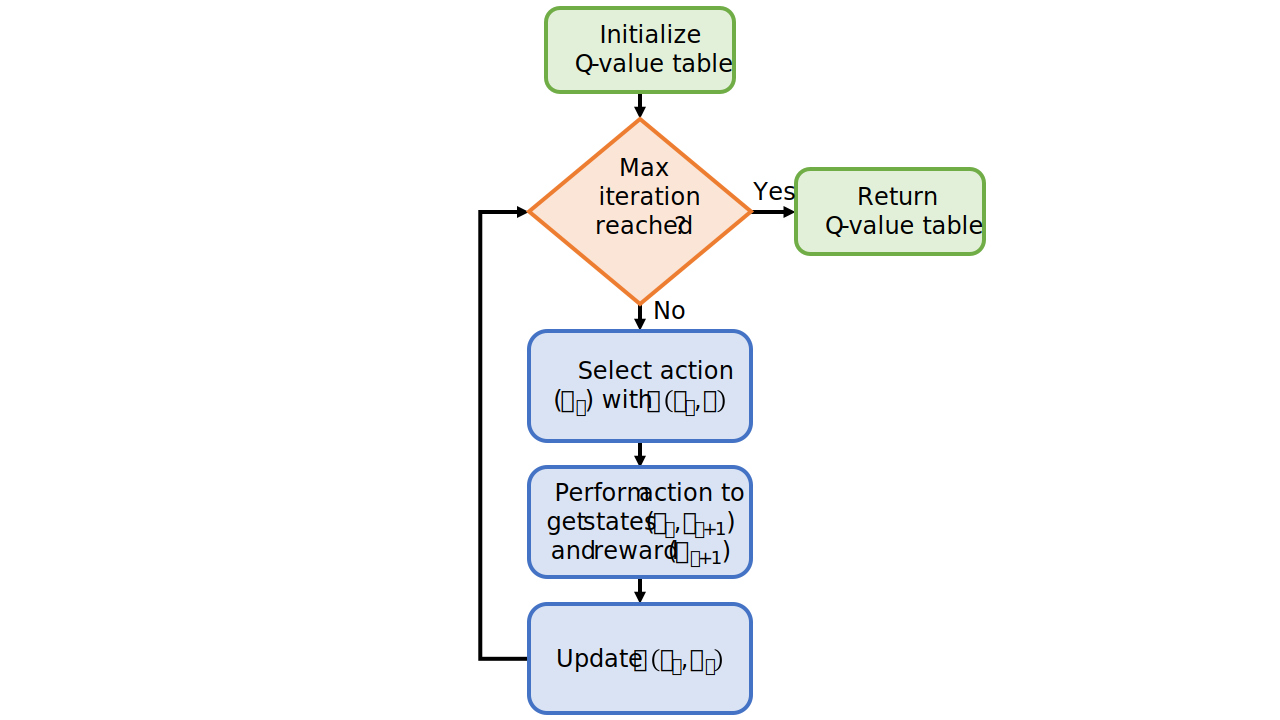

In [5]:
display(SVG(url="https://drive.google.com/uc?id=18tNqr_KU5_zjZcO11e_MwHrI3WZ8sWte"))

The diagram above visualizes the Q-learning algorithm. The Q-table is what the algorithm learns, so it is both the entry and exit point of the algorithm. The Q-table has to be initialized randomly as Q-values will be updated iteratively. The iteration number refers to the number of times the Q-values in the Q-table are updated during the learning process. This number needs to be specified in advance and is always problem-specific. The three blue boxes each represent an interaction between the agent and its environment and are a different way of visualizing the same interactions we saw previously for the MDP. These three interactions are inserted into the previous MDP diagram, and the result is shown below. Let's go through these interactions one by one.

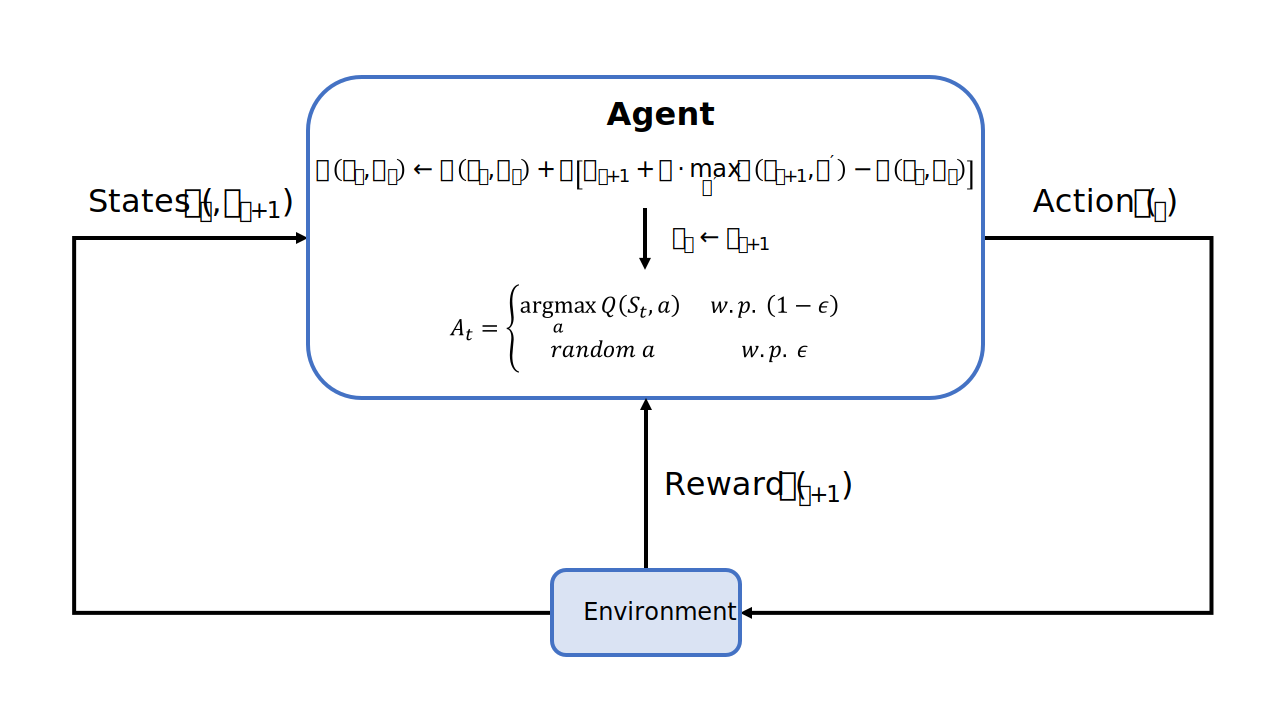

In [6]:
display(SVG(url="https://drive.google.com/uc?id=1ZE8QwLwvN2D7wpR1Y5e8tZxez1HabdVe"))

### Select action ($A_{t}$) with $Q(S_{t}, a)$

The first step of a Q-learning iteration, labeled as iteration $t$, is the agent selecting an action $A_{t}$. To select $A_{t}$, the agent uses the current state $S_{t}$ that it received from the environment and the  current version of the Q-table. Specifically, the agent chooses the action which, paired with the current state, has the highest Q-value in the Q-table. This is the agent's best guess for the action that would maximize the return for the rest of the episode given the current state. The mathematical formulation of the action selection is shown below.

Another important concept that is introduced here is the exploration-exploitation tradeoff, which is fundamental to any RL problem. The tradeoff refers to the conflict between two behaviors that the agent can adopt when trying to find the optimal policy, or in our case, the optimal Q-table. Exploration is the first behavior the agent can adopt. This refers to the agent trying out new actions to see if any are potentially better than the ones it currently knows. The upside of exploration is that it potentially leads to better policies (therefore higher returns) in the long term, while the downside is that it inevitably reduces the returns in the short term. Exploitation is the second behavior the agent can adopt. This refers to the agent wanting to maximize the return immediately by taking the actions it knows lead to a high reward (actions with the highest Q-values). The upside of exploitation is that it maximizes the return in the short term, while the downside is that it leaves potentially better policies that yield higher returns undiscovered.

These two behaviors directly clash with one another, but both are necessary to find the approximate best policy, while still exploiting it as much as possible before time runs out. Therefore, the agent has to adopt a tradeoff between these two behaviors, which is expressed mathematically below with the $\epsilon$ parameter. $\epsilon$ represents the probability that the agent selects a completely random action (explores), while $(1-\epsilon)$ represents the probability that the agent selects the action with the highest Q-value (exploits). The $\epsilon$ parameters allow the agent to balance the upsides and downsides of the two behaviors.

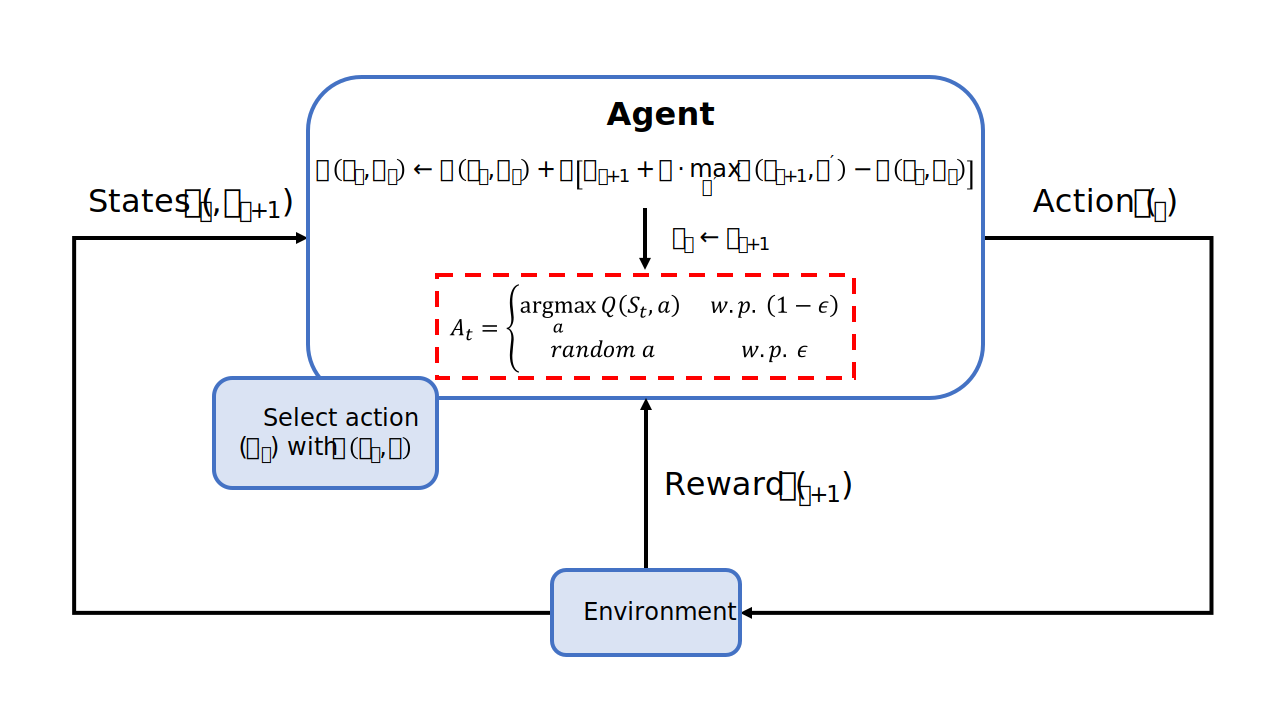

In [7]:
display(SVG(url="https://drive.google.com/uc?id=1JWmaXki5OOpx8N_4AhEcOMa_5suxsYnu"))

### Perform action to get states $(S_{t}, S_{t+1})$ and reward $(R_{t+1})$

The second step of a Q-learning iteration is to perform the action $A_{t}$ the agent selected and to observe it's effects on the environment. Upon being altered by action $A_{t}$, the environment returns the previous state $S_{t}$, as well as new state $S_{t+1}$ which reflects the alterations. The environment also returns the reward $R_{t+1}$ grading the alterations that action $A_{t}$ caused. All this information that the environment send to the agent is visualized below. It will then be used in the the third step of the Q-learning iteration.

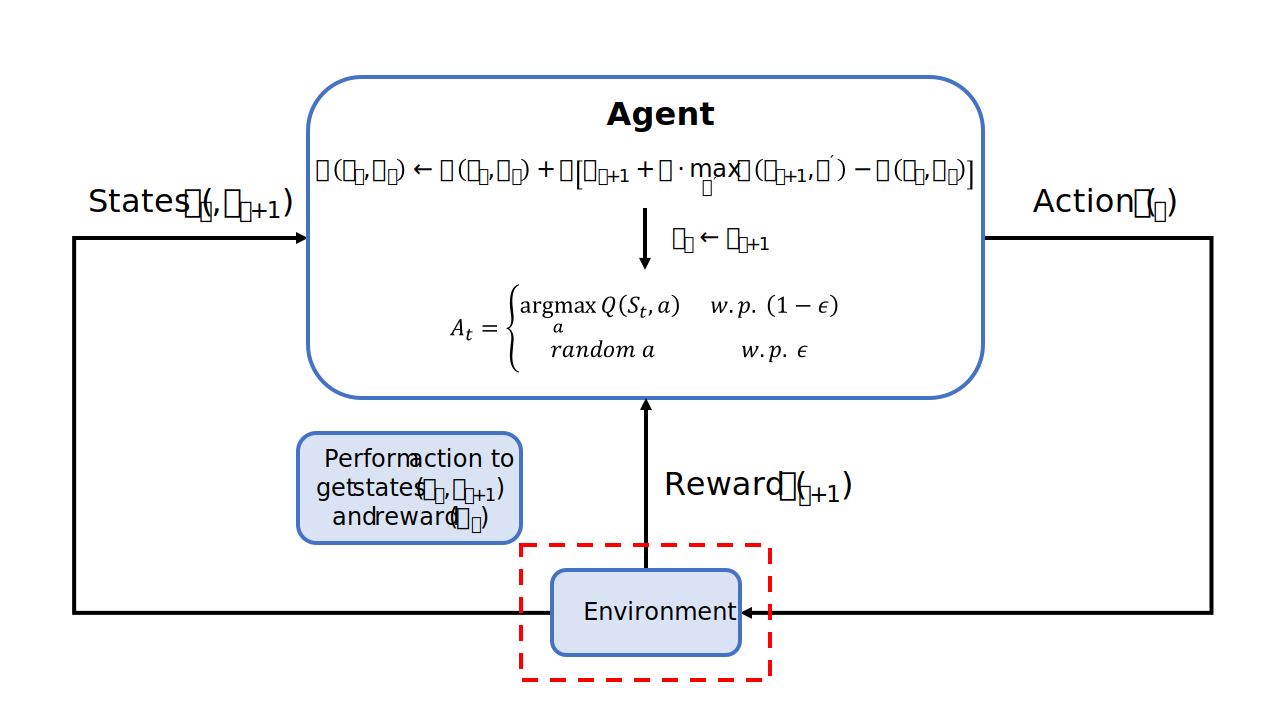

In [8]:
display(SVG(url="https://drive.google.com/uc?id=1wx7YNxZnfh4xBseWujlUIO82CmVNsx1d"))

### Update $Q(S_{t}, A_{t})$

The third and final step of a Q-learning iteration is to use the information the agent recieved from the environment after it was altered to update the Q-value of the previous state-action pair. As we have stated previously, the Q-values are updated iterativaly. The mathematical formulation of the update rule is shown below.

$$
Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \alpha \cdot [R_{t+1} +  \gamma \cdot \underset{a'}{\mathrm{max}} Q(S_{t+1}, a') - Q(S_{t}, A_{t})]
$$

Where:
- $Q(S_{t}, A_{t})$ is the Q-value of the state-action pair of timestep $t$
- $\alpha$ is the learning rate
- $R_{t+1}$ is the reward returned by the environment after action $A_{t}$ altered it
- $\gamma$ is the discount rate
- $S_{t+1}$ is the new state of the environment after action $A_{t}$ altered it
- $a'$ is the set of next actions the agent can take upon recieving the new state $S_{t+1}$

The only new term in the equation above is the learning rate $\alpha$. This parameter scales the updates that are applied to Q-values. The updates to Q-values attempt to correct the error of their previous estimations. The $R_{t+1} +  \gamma \cdot \underset{a'}{\mathrm{max}} Q(S_{t+1}, a')$ part of the update represents the target the Q-value needs to be moved towards. This target is most likely a better estimate of the actual value of the state-action pair $(S_{t}, A_{t})$ than the previous Q-value $ Q(S_{t}, A_{t})$. Remember that the actual value of a state-action pair is the expected return that ensues if we knew the optimal policy, while Q-values are estimations of those actual values under the current policy that the agent is in the process of learning.

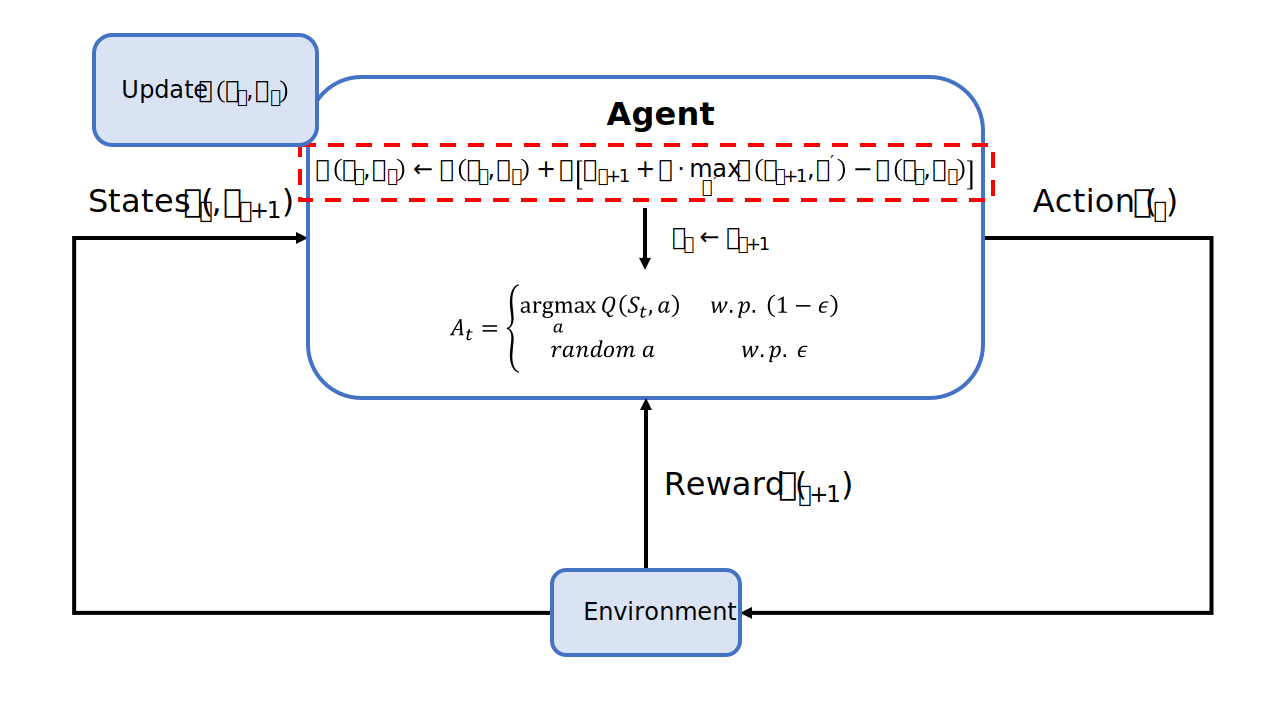

In [9]:
display(SVG(url="https://drive.google.com/uc?id=1RUNGtpzkHx1FpocCOunm5HMOeK_1s3-u"))

## 1.3 Q-Learning for stock trading with 1 discrete technical indicator
---

### **Simplified discrete** stock trading problem with Q-Learning

Now that we've defined the key points of the Q-learning algorithm, we can use it to solve the first and simplest iteration of the stock trading problem as an RL problem. To solve the stock trading problem with the Q-learning algorithm, it has to be defined throughout the three MDP components that we described earlier, namely the states, actions, and rewards.

### States

### Actions

### Rewards

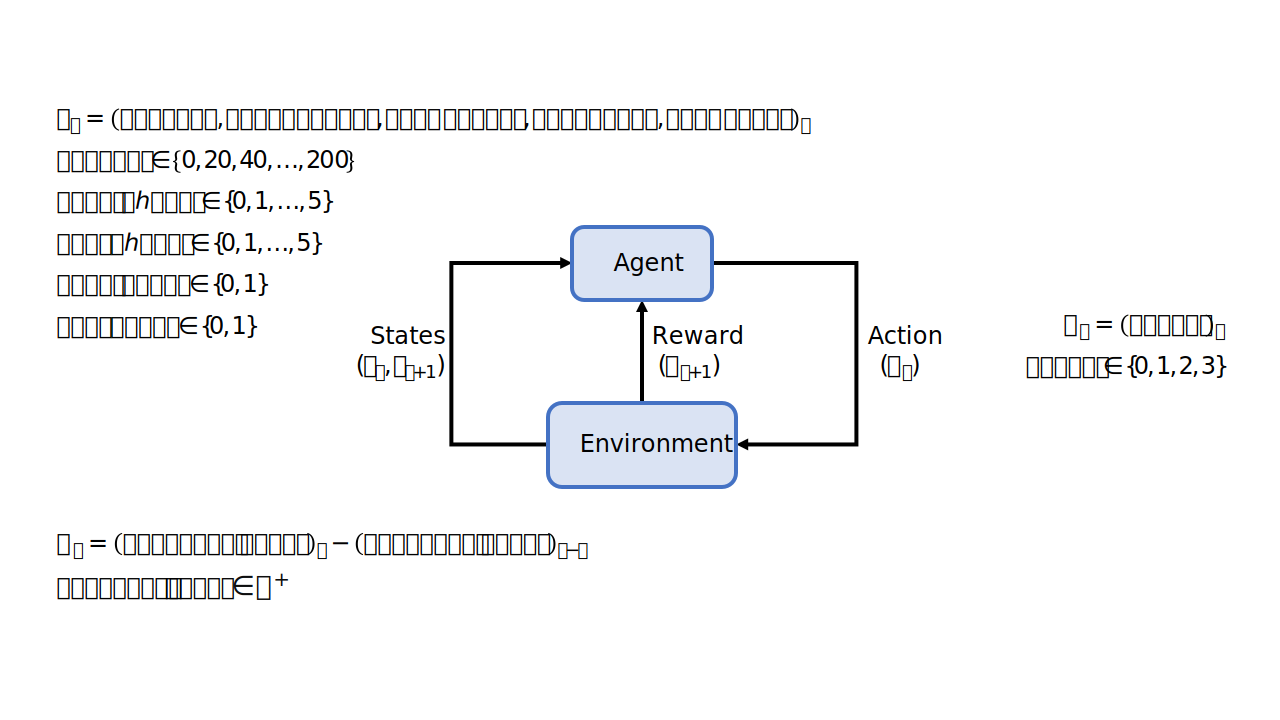

In [10]:
display(SVG(url="https://drive.google.com/uc?id=1DH0v4JL-LdOG4pGEl6-fYH8uXPxhJmUV"))

## 1.4 Experiment 1: **Simplified discrete** stock trading problem
---

In [11]:
class TradingEnvironment:
    """
    Our basic Environment Class, it implements all the common methods of MDP Environment
    """

    def __init__(
        self, pepsi_file: str, cola_file: str, observation_dim: int, action_dim: int
    ):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.pepsi_data = pd.read_csv(pepsi_file)
        self.pepsi_data.Name = "Pepsi"
        self.cola_data = pd.read_csv(cola_file)
        self.cola_data.Name = "Cola"

        self.action_space = range(action_dim)
        self.state = np.zeros(observation_dim)

        self.current_step = 0
        self.portfolio_value = self._compute_portfolio_value()

    def step(self, action: int) -> Tuple[np.ndarray | int, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()
        return self.state, reward, done

    @abstractmethod
    def reset(self) -> np.ndarray | int:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _trade(self, action: int) -> np.ndarray:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _get_indicator(self, stock_data: pd.DataFrame) -> int | float:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _check_action_validity(self, action: int) -> None:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _compute_portfolio_value(self) -> float:
        # Not Implemented
        raise NotImplementedError

    def _get_stock_price(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Fetch the price for the given step and stock
        """
        return stock_data.iloc[step]["Close"]

    def _get_stock_trend(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Fetch the trend for the given stock between the given step and the previous one
        """
        return stock_data.iloc[step]["Close"] - stock_data.iloc[step - 1]["Close"]

    def _compute_reward(self) -> float:
        """
        Computes and updates the portfolio value and returns the reward associated
        The reward is the difference between the current portfolio value and the previous one
        """
        current_portfolio_value = self._compute_portfolio_value()
        reward = current_portfolio_value - self.portfolio_value
        self.portfolio_value = current_portfolio_value
        return reward

In [12]:
class SimplifiedDiscreteTradingEnvironment(TradingEnvironment):
    """
    The environment corresponding to the 1st experiment.

    State space = {0..10} x {0..5} x {0..5} x {0,1} x {0,1}
        representing respectively
            the remaining balance,
            the number of pepsi shares held,
            the number of cola shares held,
            the trend of pepsi stock,
            the trend of cola stock

    Action space = {0..3} for
        0: Sell all
        1: Hold
        2: Buy Pepsi
        3: Buy Cola

    The state is represented with an index in {0..1584} for Q-value tables
    """

    def __init__(self, pepsi_file: str, cola_file: str):
        self.observation_dim = (
            5  # [Balance, Shares Pepsi, Shares Cola, Trend Pepsi, Trend Cola]
        )
        self.action_dim = 4  # 0 = Sell all, 1 = Hold, 2 = Buy Pepsi, 3 = Buy Cola

        self.balance_unit = 10
        self.max_balance_units = 10
        self.max_shares_per_stock = 5

        self.max_state_index = (
            11 * 6 * 6 * 2 * 2
        )  # 11 balances, 6 shares each for Pepsi and Cola, 2 trends each

        super().__init__(pepsi_file, cola_file, self.observation_dim, self.action_dim)

        self.state = np.array(
            [10, 0, 0, 0, 0]
        )  # Initial state: [Balance, Pepsi shares, Cola shares, Trend of Pepsi, Trend of Cola]

    def __str__(self) -> str:
        info = """The environment is a Simplified Discrete Trading Problem (Experiment 1).\n
        It is using the stocks: {}, {}
        The episode is at the timestep {}
        The current stock prices are {}$ and {}$
        Amount of shares held by the agent: {}
        Left balance: {}""".format(
            self.pepsi_data.Name,
            self.cola_data.Name,
            self.current_step,
            np.round(self._get_stock_price(self.current_step, self.pepsi_data), 2),
            np.round(self._get_stock_price(self.current_step, self.cola_data), 2),
            self.state[1:3],
            self.state[0],
        )

        return info

    def step(self, action: int) -> Tuple[int, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            next_state_index: int, The index of the next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()
        state_index = self.convert_state_to_index(self.state)
        return state_index, reward, done

    def reset(self) -> int:
        """
        Reset the environment to its initial State

        Returns:
            state_index: int, The initial state as index
        """
        self.state = np.array([10, 0, 0, 0, 0])
        self.current_step = 0
        self.portfolio_value = self._compute_portfolio_value()
        state_index = self.convert_state_to_index(self.state)
        return state_index

    def _trade(self, action: int) -> np.ndarray:
        """
        Trade the desired amount

        Args:
            action: int, The trade order, can be
                - 0: Sell all
                - 1: Hold
                - 2: Buy Pepsi
                - 3: Buy Cola

        Returns:
            state: np.ndarray, The state after the trade
        """
        balance_units, shares_pepsi, shares_cola = (
            self.state[0],
            self.state[1],
            self.state[2],
        )
        balance = balance_units * self.balance_unit
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)

        if action == 0:  # Sell all
            balance += shares_pepsi * pepsi_price + shares_cola * cola_price
            shares_pepsi, shares_cola = 0, 0
        elif action == 2:  # Buy Pepsi
            quantity = min(
                balance // pepsi_price, self.max_shares_per_stock - shares_pepsi
            )
            shares_pepsi += quantity
            balance -= quantity * pepsi_price
        elif action == 3:  # Buy Cola
            quantity = min(
                balance // cola_price, self.max_shares_per_stock - shares_cola
            )
            shares_cola += quantity
            balance -= quantity * cola_price

        # Update state with rounded balance
        new_balance = min(int(balance / self.balance_unit), self.max_balance_units)

        trend_pepsi = self._get_indicator(self.current_step, self.pepsi_data)
        trend_cola = self._get_indicator(self.current_step, self.cola_data)

        return np.array(
            [new_balance, shares_pepsi, shares_cola, trend_pepsi, trend_cola]
        )

    def _get_indicator(self, step: int, stock_data: pd.DataFrame) -> int:
        """
        Compute the indicator used as observation. The

        Args:
            step: int, the current step of the episode
            stock_data: pd.DataFrame, the stock data from which one wants to get the indicator

        Returns
            indicator: int, The indicator giving the trend information (1 for rising, 0 for falling)
        """
        trend = self._get_stock_trend(step, stock_data)
        indicator = int(trend > 0)
        return indicator

    def _check_action_validity(self, action: int) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        if action not in range(self.action_dim):
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        """
        Compute the current porfolio value
        """
        balance = self.state[0] * self.balance_unit
        pepsi_holdings_value = self.state[1] * self._get_stock_price(
            self.current_step, self.pepsi_data
        )
        cola_holdings_value = self.state[2] * self._get_stock_price(
            self.current_step, self.cola_data
        )
        return balance + pepsi_holdings_value + cola_holdings_value

    def convert_state_to_index(self, state: np.ndarray) -> int:
        balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola = state
        index = balance_index
        index += pepsi_shares * 11
        index += cola_shares * 11 * 6
        index += trend_pepsi * 11 * 6 * 6
        index += trend_cola * 11 * 6 * 6 * 2
        return int(index)

    def convert_index_to_state(self, index: int) -> np.ndarray:
        trend_cola = index // (11 * 6 * 6 * 2)
        index %= 11 * 6 * 6 * 2
        trend_pepsi = index // (11 * 6 * 6)
        index %= 11 * 6 * 6
        cola_shares = index // (11 * 6)
        index %= 11 * 6
        pepsi_shares = index // 11
        balance_index = index % 11
        return np.array(
            [balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola]
        )

In [13]:
class QLearningAgent:
    """
    The class implementing our agent for Experiment 1
    """

    def __init__(
        self,
        state_space: int,
        action_space: int,
        learning_rate=0.01,
        discount_factor=0.99,
        exploration_rate=1.0,
    ):
        # Env
        self.state_space = state_space
        self.max_state_index = 11 * 6 * 6 * 2 * 2
        self.action_space = action_space

        # Learning
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.q_table = np.zeros((self.max_state_index, action_space))

        # Monitoring
        self.q_table_to_store = np.zeros((11, 6, 6, 2, 2, action_space))
        self.q_table_history = np.zeros((1, 11, 6, 6, 2, 2, action_space))

    def __str__(self) -> str:
        info = """The agent is using Q-Learning algorithm\n
        It is working on Simplified Discrete Trading Environment (Experiment 1)\n
        The current Q Table values can be fetch by calling get_current_q_values() method\n
        The history of Q Table values can be fetch by calling get_history_q_values() method"""
        return info

    def choose_action(self, state_index: int) -> int:
        """
        Choose action according to current Q Table

        Args:
            state_index: int, The index corresponding to the state in which the environment is in

        Returns:
            action: int, The action picked according to the current Q-values
        """
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        return np.argmax(self.q_table[state_index])

    def train(
        self, state_index: int, action: int, reward: float, next_state_index: int
    ) -> None:
        """
        Update Q values following Q Learning classical update

        Args:
            state_index: int, The index corresponding to the state in which the environment was before taking the action
            action: int, The action picked by the agent
            reward: float, The reward that was returned by the environment after the agent took the action
            next_state_index: int, The index corresponding to the state in which the environment is after taking the action
        """
        assert 0 <= state_index < self.max_state_index, "Invalid state_index"
        assert 0 <= next_state_index < self.max_state_index, "Invalid next_state_index"

        q_value = self.q_table[state_index, action]

        # Target = Rt + Gamma x max(Q[S(t+1), a])
        target = reward + self.discount_factor * np.max(self.q_table[next_state_index])

        # Q[S(t), action] =  Q[S(t), action] + alpha x (Rt + Gamma x max(Q[S(t+1), a]) - Q[S(t), action])
        self.q_table[state_index, action] += self.learning_rate * (target - q_value)

        # Update Q table for monitoring
        state = self.convert_index_to_state(state_index)
        self.q_table_to_store[
            state[0], state[1], state[2], state[3], state[4], action
        ] = self.q_table[state_index, action]

        self.exploration_rate = max(
            self.exploration_rate * self.exploration_decay, self.exploration_min
        )

    def store_q_values(self) -> None:
        """
        Stores the current Q-values table in the q_table_history array
        """
        self.q_table_history = np.concatenate(
            (self.q_table_history, [self.q_table_to_store])
        )

    def get_current_q_values(self) -> np.ndarray:
        """
        Fetch the current Q Table as a numpy array of shape:
            (number of possible states, number of possible actions)
        """
        return self.q_table

    def get_history_q_values(self) -> np.ndarray:
        """
        Fetch the history of Q Tables as a numpy array of shape:
            (number of episodes seen, number of possible states, number of possible actions)
        """
        return self.q_table_history

    def convert_index_to_state(self, index: int) -> np.ndarray:
        trend_cola = index // (11 * 6 * 6 * 2)
        index %= 11 * 6 * 6 * 2
        trend_pepsi = index // (11 * 6 * 6)
        index %= 11 * 6 * 6
        cola_shares = index // (11 * 6)
        index %= 11 * 6
        pepsi_shares = index // 11
        balance_index = index % 11
        return np.array(
            [balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola]
        )

In [14]:
def train_QLearning_agent(
    env: SimplifiedDiscreteTradingEnvironment, agent: QLearningAgent, num_episodes: int
):
    """
    Performs the training of the Agent for experiment 1

    Args:
        env: SimplifiedDiscreteTradingEnvironment, The Environment which the agent will interact with
        agent: QLearningAgent, The agent that will be trained
        num_episodes: int, The number of episode which the agent will be trained on

    Returns:
        rewards_per_episode: list, The history of rewards over the episodes
        q_values_array: np.ndarray, The history of Q-values tables over the episodes
    """

    rewards_per_episode = []

    for episode in range(num_episodes):
        state_index = env.reset()  # Get the initial state index
        total_rewards = 0

        done = False
        while not done:
            action = agent.choose_action(state_index)
            next_state_index, reward, done = env.step(
                action
            )  # next_state_index is directly obtained here
            agent.train(state_index, action, reward, next_state_index)

            state_index = next_state_index
            total_rewards += reward

        agent.store_q_values()

        rewards_per_episode.append(total_rewards)
        print(f"Episode: {episode}, Total Reward: {total_rewards}")

    q_values_array = agent.get_history_q_values()

    plt.plot(rewards_per_episode)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    return rewards_per_episode, q_values_array

Episode: 0, Total Reward: -80.0
Episode: 1, Total Reward: -60.0
Episode: 2, Total Reward: -60.0
Episode: 3, Total Reward: -60.0
Episode: 4, Total Reward: -50.0
Episode: 5, Total Reward: -36.38999938964844
Episode: 6, Total Reward: -60.0
Episode: 7, Total Reward: -50.0
Episode: 8, Total Reward: -50.0
Episode: 9, Total Reward: -40.0
Episode: 10, Total Reward: -26.389999389648438
Episode: 11, Total Reward: -40.0
Episode: 12, Total Reward: -16.389999389648438
Episode: 13, Total Reward: 0.0
Episode: 14, Total Reward: -30.0
Episode: 15, Total Reward: 0.0
Episode: 16, Total Reward: -40.0
Episode: 17, Total Reward: -60.0
Episode: 18, Total Reward: -60.0
Episode: 19, Total Reward: -50.0
Episode: 20, Total Reward: 27.220001220703125
Episode: 21, Total Reward: -40.0
Episode: 22, Total Reward: -16.389999389648438
Episode: 23, Total Reward: -50.0
Episode: 24, Total Reward: -36.38999938964844
Episode: 25, Total Reward: -26.389999389648438
Episode: 26, Total Reward: -16.389999389648438
Episode: 27, T

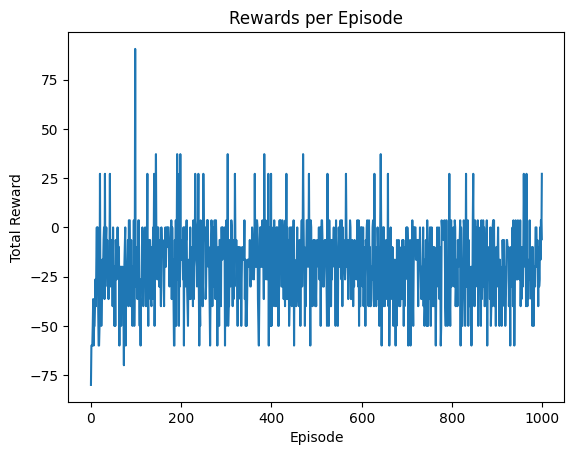

In [15]:
EnvExp1 = SimplifiedDiscreteTradingEnvironment("pepsi_data.csv", "cola_data.csv")
AgentExp1 = QLearningAgent(state_space=5, action_space=4)
rewards = train_QLearning_agent(env=EnvExp1, agent=AgentExp1, num_episodes=1000)

In [16]:
_, q_values_array = rewards
q_values_array.shape

(1001, 11, 6, 6, 2, 2, 4)

## 1.5 Experiment 1 results
---

### Performance

Plot and analyse results...

### Learned Q-values

In [29]:
def plot_Q_value_evolution(q_values_array, state_variable, state_variable_ticks):
    """
    Function that plots the Q-value evolution relative to 1 state variable

    Args:
        q_values_array: [1000, 11, 6, 6, 2, 2, 4] array, containing the history episode-wise of the Q-table learned by the agent
        state_variable: string, the name of the state variable for which the Q-table will be plotted
        state_variable_ticks: list-like, discretization of the state variable for which the Q-table will be plotted

    Returns:
        plotly figure displaying the Q-table history as a heatmap
    """


    # Average out the state variables that arent displayed
    if state_variable == 'Balance':
      q_values_array_avg = np.mean(q_values_array, axis=(2,3,4,5))
    elif state_variable == 'Pepsi shares':
      q_values_array_avg = np.mean(q_values_array, axis=(1,3,4,5))
    elif state_variable == 'Cola shares':
      q_values_array_avg = np.mean(q_values_array, axis=(1,2,4,5))
    elif state_variable == 'Pepsi trend':
      q_values_array_avg = np.mean(q_values_array, axis=(1,2,3,5))
    elif state_variable == 'Cola trend':
      q_values_array_avg = np.mean(q_values_array, axis=(1,2,3,4))

    # Define the figure that will plot Q-value tables as heatmaps
    fig = make_subplots(rows=1, cols=1)
    layout = go.Layout(
        title_x=0.5,
        height=400,
        width=800,
        xaxis=dict(
            title=dict(text=state_variable),
            tickmode='array',
            tickvals=np.arange(q_values_array_avg.shape[1]),
            ticktext=state_variable_ticks
        ),
        yaxis=dict(
            title=dict(text='Action'),
            tickmode='array',
            tickvals=np.arange(4),
            ticktext=['Sell all', 'Hold', 'Buy Pepsi', 'Buy Cola']
        )
    )
    fig.update_layout(layout)

    # Add Q-value tables to the figure, for each 100th training episode
    q_values_array_avg = q_values_array_avg[np.arange(0, 1001, 100), :]
    for episode in range(q_values_array_avg.shape[0]):
        trace = go.Heatmap(
            z=q_values_array_avg[episode].transpose(),
            visible=False,
            colorbar=dict(title='Q-value'),
            colorscale='RdBu_r',
            zmid=0
        )
        fig.add_trace(trace)
    fig.update_layout(
        coloraxis=dict(
            cmin=q_values_array_avg.min(),
            cmax=q_values_array_avg.max(),
            cmid=0)
     )

    # Create episode slider
    episodes = []
    for i in range(len(fig.data)):
        episode_label = 'Episode: ' + str(100 * i)
        episode = dict(
            method='update',
            label=episode_label,
            args=[
                {'visible': [False] * len(fig.data)},
                {'title': episode_label}
            ]
        )
        episode['args'][0]['visible'][i] = True
        episodes.append(episode)

    sliders = [dict(
        steps=episodes,
        active=0
    )]
    fig.update_layout(sliders=sliders)

    # Display figure
    fig.show()

In [35]:
state_variable = 'Balance'
state_variable_ticks = np.arange(0, 220, 20)
plot_Q_value_evolution(q_values_array, state_variable, state_variable_ticks)

In [31]:
state_variable = 'Pepsi shares'
state_variable_ticks = np.arange(0, 6, 1)
plot_Q_value_evolution(q_values_array, state_variable, state_variable_ticks)

In [32]:
state_variable = 'Cola shares'
state_variable_ticks = np.arange(0, 6, 1)
plot_Q_value_evolution(q_values_array, state_variable, state_variable_ticks)

In [33]:
state_variable = 'Pepsi trend'
state_variable_ticks = ['Down', 'Up']
plot_Q_value_evolution(q_values_array, state_variable, state_variable_ticks)

In [34]:
state_variable = 'Cola trend'
state_variable_ticks = ['Down', 'Up']
plot_Q_value_evolution(q_values_array, state_variable, state_variable_ticks)

Display leanred Q-value table and gain insight...

# Part 2. **Simplified continuous** stock trading problem
---
---

Explain...

## 2.1 Function approximation
---

Explain...

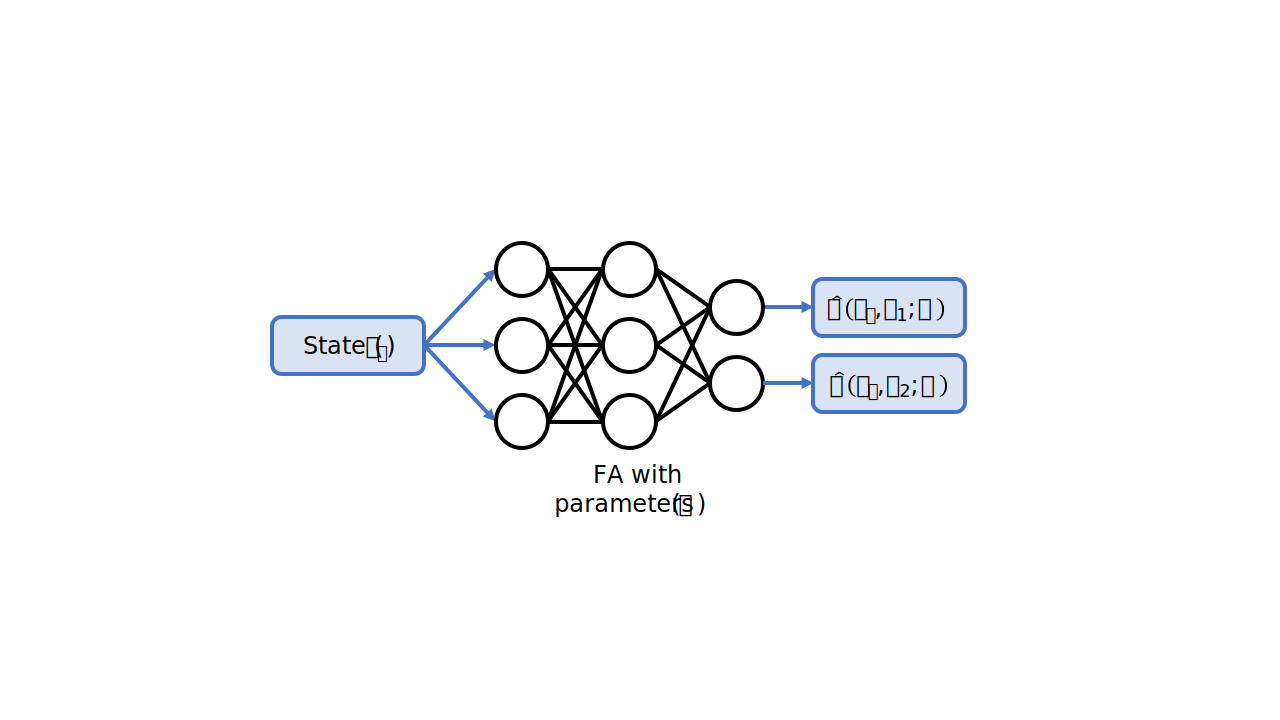

In [36]:
display(SVG(url="https://drive.google.com/uc?id=1re42wSrEdf7diTiewsS-eCUM3UBOeTVt"))

## 2.2 Deep Q-Learning
---

Deep Q-Learning introduction...

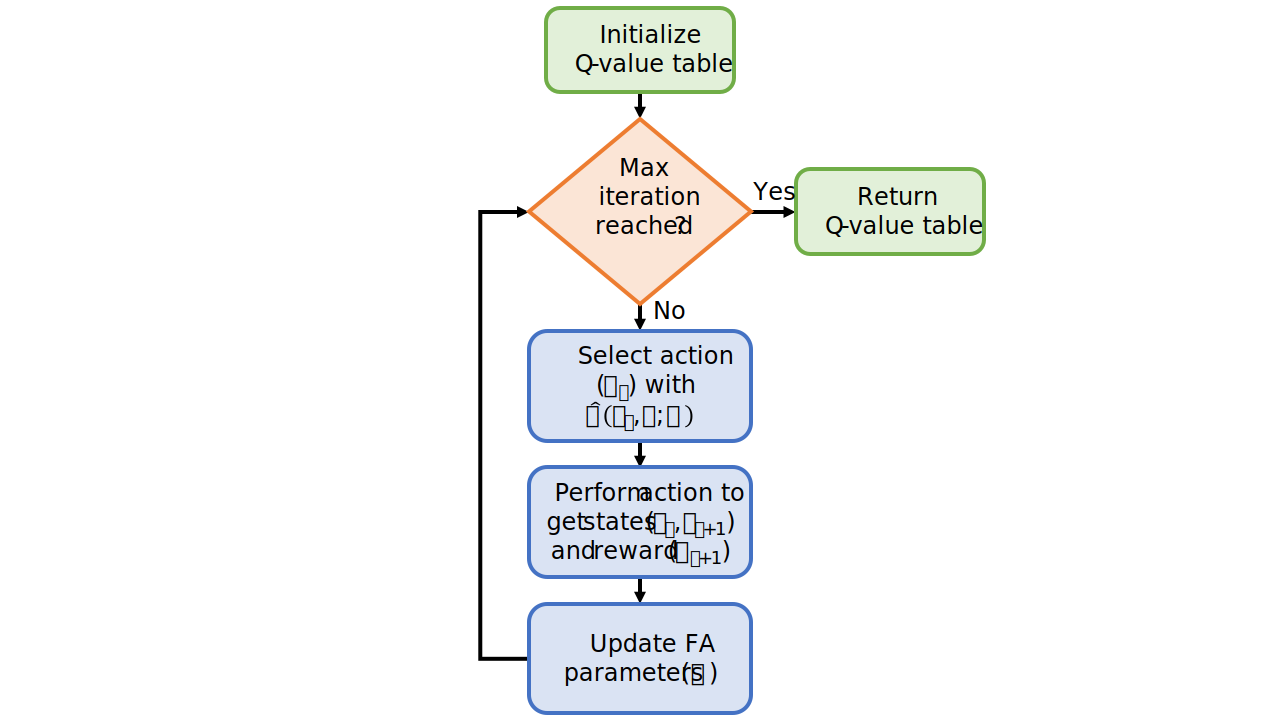

In [37]:
display(SVG(url="https://drive.google.com/uc?id=1ffb8usVzTsyYwGF-TlZhGJu-9IBpLCj1"))

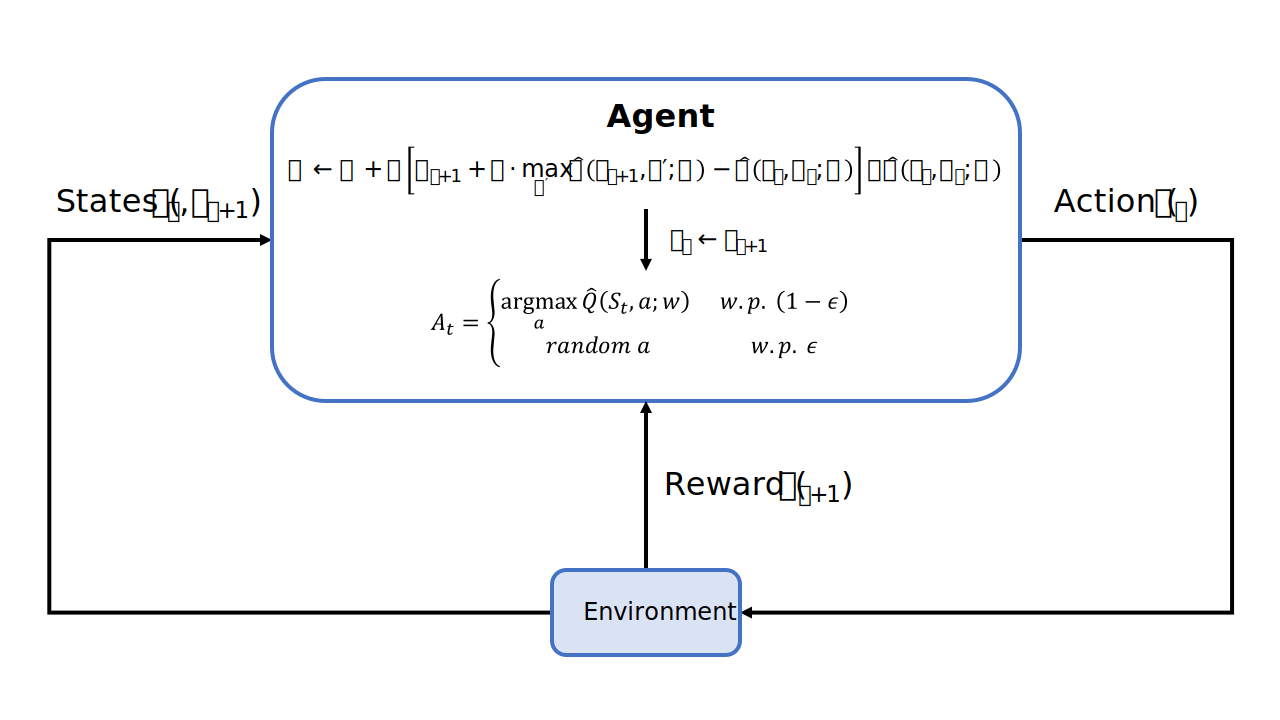

In [38]:
display(SVG(url="https://drive.google.com/uc?id=1QUFuAOlroZLqrLardHxFyPoU3a86L_nL"))

### Select an action ($A_{t}$) with $\hat{Q}(S_{t}, a; w)$

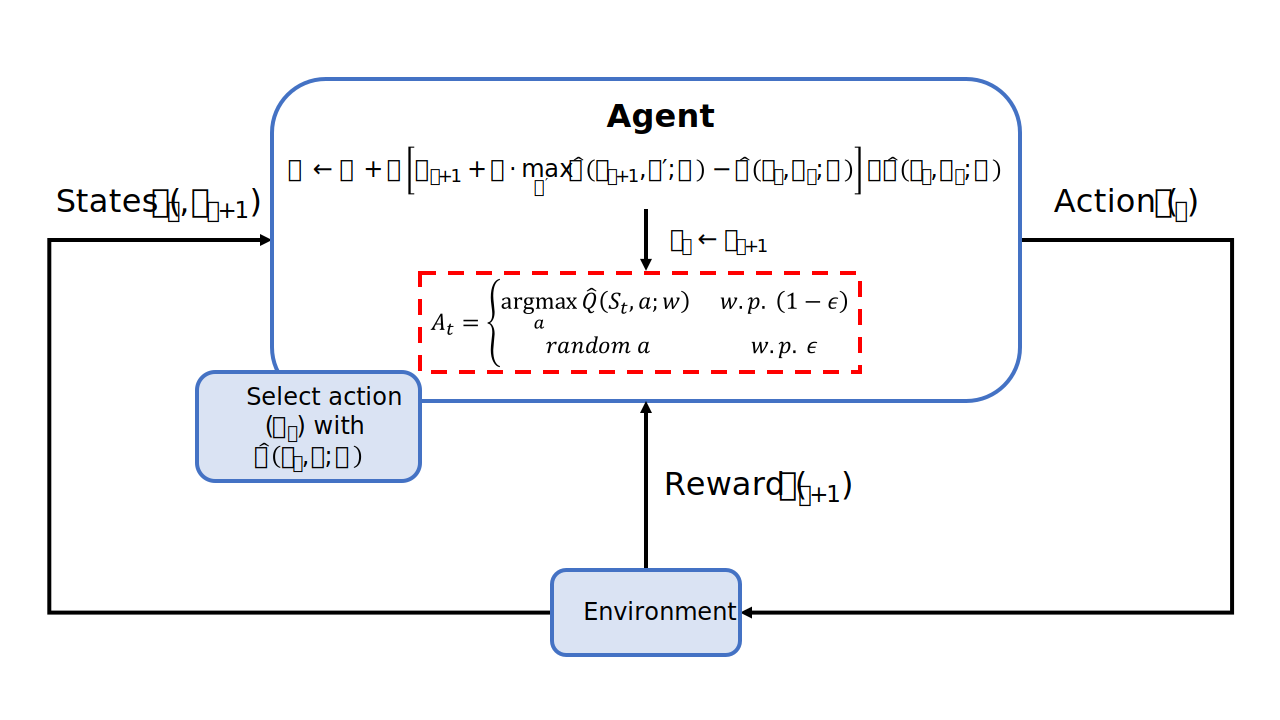

In [26]:
display(SVG(url="https://drive.google.com/uc?id=1EOnG3LjjkFLcFY7cN8G0jTlu4-RFSkOy"))

### Update FA parameters ($w$)

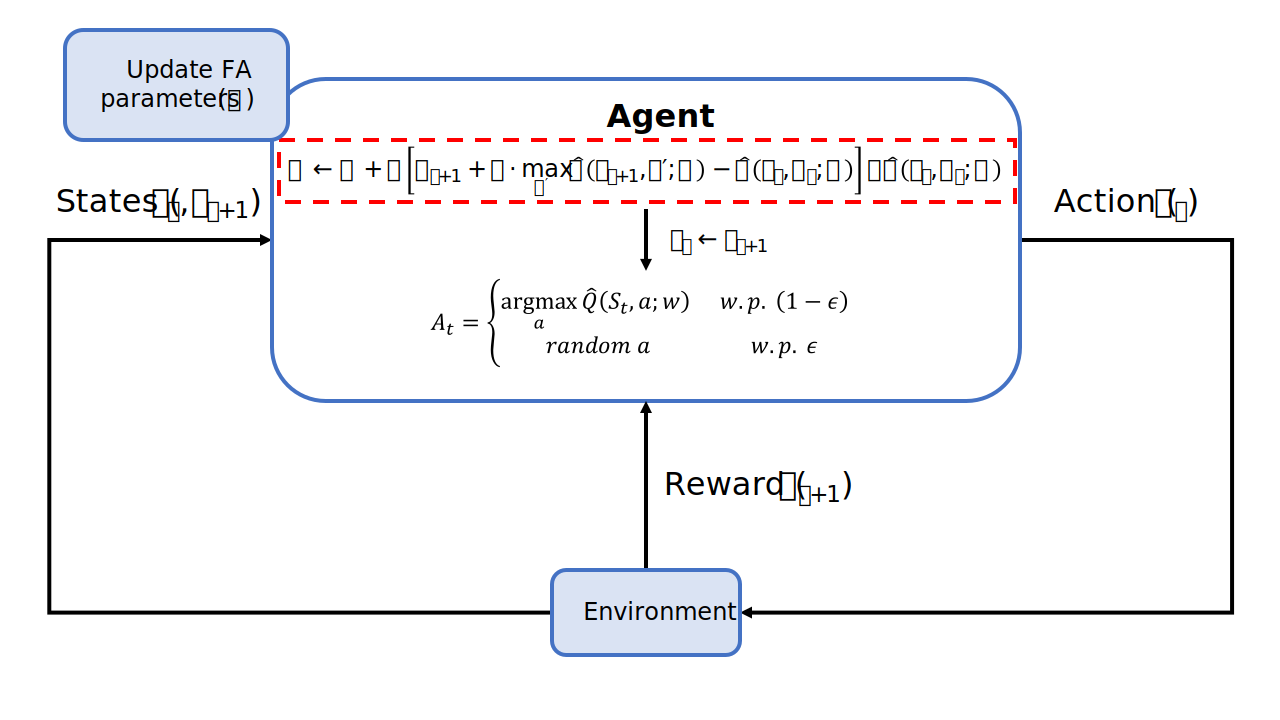

In [27]:
display(SVG(url="https://drive.google.com/uc?id=1ZPu51q_dEXcNw54ZytmcvIlUjCNDiMly"))

## 2.3 Deep Q-Learning for stock trading with 1 continuous technical indicator
---

### **Simplified continuous** stock trading problem with deep Q-Learning

### States

### Actions

### Rewards

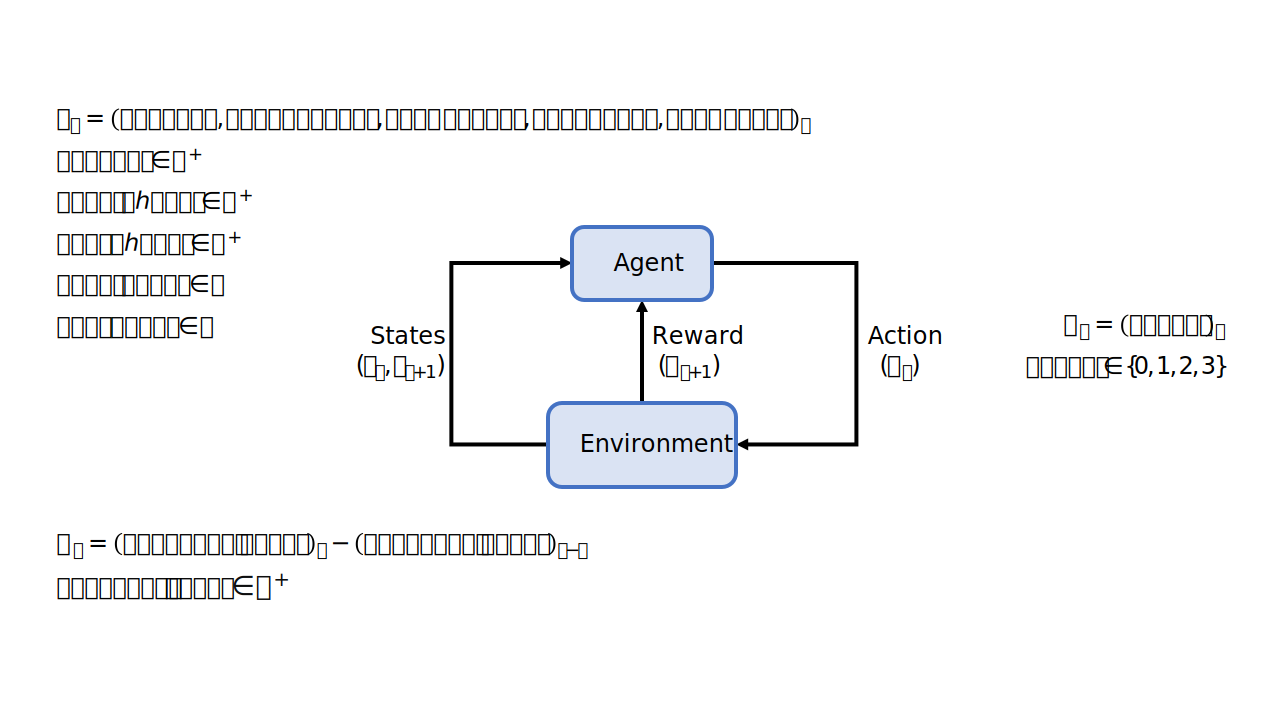

In [39]:
display(SVG(url="https://drive.google.com/uc?id=1O6Sb2jlPU1SA91N1MSbqL-gp4cnwC110"))

## 2.4 Experiment 2: **Simplified continuous** stock trading problem
---

In [ ]:
class SimplifiedContinuousTradingEnvironmentDQN(TradingEnvironment):
    def __init__(self, pepsi_file, cola_file):
        observation_dim = (
            5  # balance, shares of Pepsi, shares of Cola, trend of Pepsi, trend of Cola
        )
        action_dim = 4  # Sell all, Hold, Buy Pepsi, Buy Cola
        super().__init__(
            pepsi_file,
            cola_file,
            observation_dim=observation_dim,
            action_dim=action_dim,
        )

        self.state = np.array([10000.0, 0, 0, 0, 0])  # Initial state

    def __str__(self) -> str:
        info = """The environment is a Simplified Continuous Trading Problem (Experiment 2).\n
        It is using the stocks: {}, {}
        The episode is at the timestep {}
        The current stock prices are {}$ and {}$
        Amount of shares held by the agent: {}
        Left balance: {}""".format(
            self.pepsi_data.Name,
            self.cola_data.Name,
            self.current_step,
            np.round(self._get_stock_price(self.current_step, self.pepsi_data), 2),
            np.round(self._get_stock_price(self.current_step, self.cola_data), 2),
            self.state[1:3],
            self.state[0],
        )

        return info

    def step(self, action: int) -> Tuple[np.ndarray, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        return super().step(action)

    def reset(self) -> np.ndarray:
        """
        Reset the environment to its initial State

        Returns:
            state: np.ndarray, The initial state
        """
        self.state = np.array([10000.0, 0, 0, 0, 0])  # Reset to initial state
        self.current_step = 0
        return self.state

    def _trade(self, action: int) -> np.ndarray:
        """
        Trade the desired amount

        Args:
            action: int, The trade order, can be
                - 0: Sell all
                - 1: Hold
                - 2: Buy Pepsi
                - 3: Buy Cola
        """
        balance, shares_pepsi, shares_cola = self.state[0], self.state[1], self.state[2]
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)

        if action == 0:  # Sell all
            balance += shares_pepsi * pepsi_price + shares_cola * cola_price
            shares_pepsi, shares_cola = 0, 0
        elif action == 2:  # Buy Pepsi
            quantity = balance / pepsi_price
            if quantity > 0:
                shares_pepsi += quantity
                balance -= quantity * pepsi_price
        elif action == 3:  # Buy Cola
            quantity = balance / cola_price
            if quantity > 0:
                shares_cola += quantity
                balance -= quantity * cola_price

        trend_pepsi = self._get_indicator(self.current_step, self.pepsi_data)
        trend_cola = self._get_indicator(self.current_step, self.cola_data)

        return np.array([balance, shares_pepsi, shares_cola, trend_pepsi, trend_cola])

    def _get_indicator(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Compute the indicator used as observation. The

        Args:
            step: int, the current step of the episode
            stock_data: pd.DataFrame, the stock data from which one wants to get the indicator

        Returns
            indicator: float, The indicator giving the trend information (price at current step - price at previous step)
        """
        return self._get_stock_trend(step, stock_data)

    def _check_action_validity(self, action: int) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        if action not in range(self.action_dim):
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        """
        Compute the current porfolio value
        """
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)
        return self.state[0] + self.state[1] * pepsi_price + self.state[2] * cola_price

In [ ]:
class DQNAgent:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []  # Memory for experience replay

        # Hyperparameters
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001

        self.model = self._build_model()

        # Monitoring
        self.model_states = []

    def _build_model(self) -> nn.Sequential:
        """
        Define a simple Neural Network model

        Returns:
            model: nn.Sequential, The model built
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size),
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool
    ) -> None:
        """
        Store the given transition into the memory for experience replay

        Args:
            state: np.ndarray, The initial state of the transition
            action: int, The action taken
            reward: float, The reward returned by the environment
            next_state: np.ndarray, The final state of the transition
            done: bool, True if the episode is terminated or truncated
        """
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state: np.ndarray) -> int:
        """
        Choose the action to pick according to current model with eps-greedy

        Args:
            state: np.ndarray, The current state

        Returns:
            action: int, The action to pick
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.from_numpy(state).float()
        with torch.no_grad():
            act_values = self.model(state)
        return np.argmax(act_values.cpu().data.numpy())

    def replay(self, batch_size: int) -> None:
        """
        Update the model parameters by experiencing through the replay buffer

        Args:
            batch_size: int, The size of the batch to experience on
        """
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.from_numpy(state).float()
            next_state = torch.from_numpy(next_state).float()
            reward = torch.tensor(reward)
            action = torch.tensor(action)
            done = torch.tensor(done)

            target = reward
            if not done:
                target = (
                    reward
                    + self.gamma * torch.max(self.model(next_state).detach()).item()
                )
            target_f = self.model(state)
            target_f[0][action] = target

            self.optimizer.zero_grad()
            loss = nn.functional.mse_loss(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def store_model(self) -> None:
        """
        Store the current model dictionnary in the variable model_states
        """
        self.model_states
        self.model_states.append(self.model.state_dict().copy())

    def generate_q_tables_1_ep(
        self, model_state: Dict, state_values: np.ndarray
    ) -> np.ndarray:
        """
        Computes the Q-values, estimated by the given model, of the given states and every actions

        Args:
            model_state: Dict[str,any], the model given as a dictionnary
            state_values: np.ndarray, The states to estimates as an array of shape
                (state space dimension, number of samples per state component)

        Returns:
            q_values: np.ndarray, The q table generated for the states provided
        """
        number_samples = state_values.shape[1]
        q_values = np.zeros(
            (
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                self.action_size,
            )
        )
        model = self._build_model()
        model.load_state_dict(model_state)
        for b in range(number_samples):
            for p in range(number_samples):
                for c in range(number_samples):
                    for tp in range(number_samples):
                        for tc in range(number_samples):
                            state = np.array(
                                [
                                    state_values[0][b],
                                    state_values[1][p],
                                    state_values[2][c],
                                    state_values[3][tp],
                                    state_values[4][tc],
                                ]
                            )
                            state_torch = torch.from_numpy(state).float()
                            q_values_from_model = model(state_torch).cpu().data.numpy()
                            q_values[b, p, c, tp, tc] = q_values_from_model
        return q_values

    def generate_q_tables(self, state_values: np.ndarray) -> np.ndarray:
        """
        Compute the Q-values estimated by the history of models learned by the agents over the episodes for the given
        state_values

        Args:
            state_values: np.ndarray, The states to estimates as an array of shape
                (state space dimension, number of samples per state component)

        Returns:
            q_values: np.ndarray, The q table generated for the states provided
        """
        number_samples = state_values.shape[1]
        number_episodes = len(self.model_states)
        print(number_episodes)
        q_values = np.zeros(
            (
                number_episodes,
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                self.action_size,
            )
        )

        for episode in range(number_episodes):
            model_state = self.model_states[episode]
            q_values_episode = self.generate_q_tables_1_ep(model_state, state_values)
            q_values[episode] = q_values_episode

        return q_values

In [ ]:
def train_dqn_agent(
    env: SimplifiedContinuousTradingEnvironmentDQN,
    agent: DQNAgent,
    num_episodes: int = 1000,
    batch_size: int = 32,
):
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(
            state, [1, env.observation_dim]
        )  # Reshape for neural network compatibility
        total_rewards = 0

        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_dim])

            agent.remember(
                state, action, reward, next_state, done
            )  # Remember the experience
            state = next_state
            total_rewards += reward

        agent.replay(batch_size)  # Train the model with experiences in memory

        rewards_per_episode.append(total_rewards)
        print(
            f"Episode: {episode + 1}, Reward: {total_rewards}, Epsilon: {agent.epsilon}"
        )

        # Storing model parameters
        agent.store_model()

    # Plot the rewards
    plt.plot(rewards_per_episode)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    return rewards_per_episode

Episode: 1, Reward: 28497.702660339528, Epsilon: 0.995
Episode: 2, Reward: -139.12416085652148, Epsilon: 0.990025
Episode: 3, Reward: -18892.369396069247, Epsilon: 0.985074875
Episode: 4, Reward: 41467.86553552019, Epsilon: 0.9801495006250001
Episode: 5, Reward: 1462.5988296822288, Epsilon: 0.9752487531218751
Episode: 6, Reward: -24329.431930974275, Epsilon: 0.9703725093562657
Episode: 7, Reward: -10387.846833485353, Epsilon: 0.9655206468094844
Episode: 8, Reward: -99.07653719313384, Epsilon: 0.960693043575437
Episode: 9, Reward: -5757.74096298527, Epsilon: 0.9558895783575597
Episode: 10, Reward: 2646.276955523139, Epsilon: 0.9511101304657719
Episode: 11, Reward: -4622.394003277448, Epsilon: 0.946354579813443
Episode: 12, Reward: 15630.687300799771, Epsilon: 0.9416228069143757
Episode: 13, Reward: -9951.935252518535, Epsilon: 0.9369146928798039
Episode: 14, Reward: 2921.114921477256, Epsilon: 0.9322301194154049
Episode: 15, Reward: 5441.6038061459985, Epsilon: 0.9275689688183278
Episod

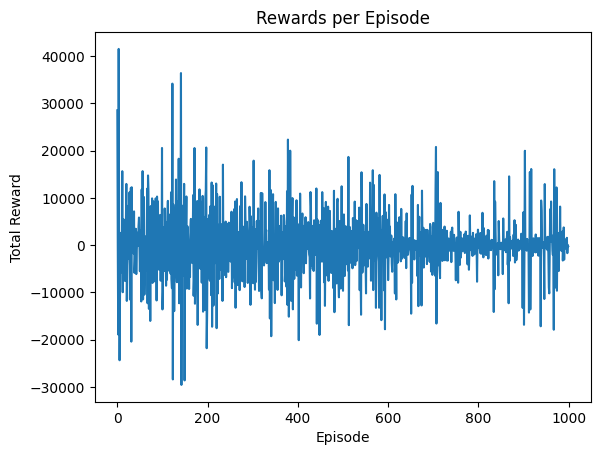

In [ ]:
EnvExp2 = SimplifiedContinuousTradingEnvironmentDQN("pepsi_data.csv", "cola_data.csv")
AgentExp2 = DQNAgent(state_size=5, action_size=4)
rewards2 = train_dqn_agent(env=EnvExp2, agent=AgentExp2, num_episodes=1000)

## 2.5 Experiment 2 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value surface and gain insight...

# Part 3. **Complete continuous** stock trading problem
---
---

Explain...

## 3.1 Deep Q-Learning for stock trading with multiple continuous technical indicators
---

### **Complete continuous** stock trading problem with deep Q-Learning

### States

### Actions

### Rewards

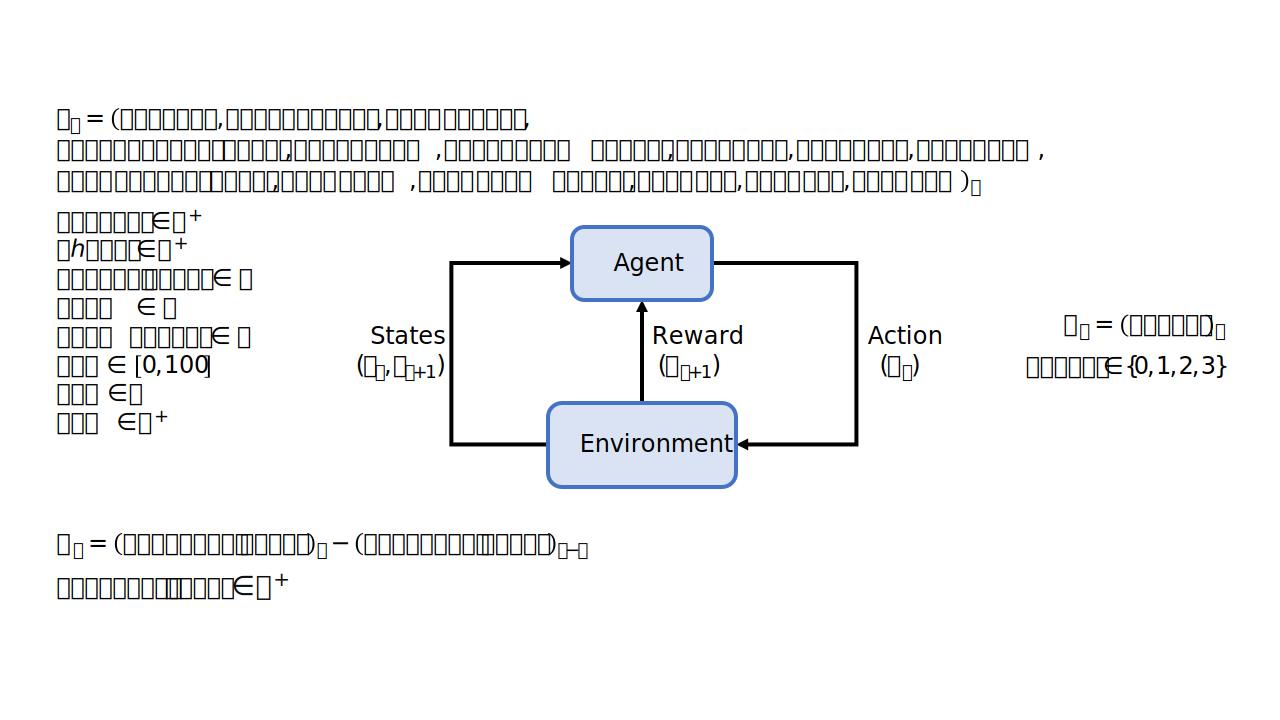

In [40]:
display(SVG(url="https://drive.google.com/uc?id=1kvqF0RLQV8ARejmXfn0IBCDpCLW9DmVo"))

## 3.2 Experiment 3: **Complete continuous** stock trading problem
---

In [ ]:
##### Overall rmq #####
# Why adj close in this env?
# Actio will be vector
# Can we buy float share quantity (e.g. buy 1.5 pepsi shares)?


class CompleteContinuousTradingEnvironment(TradingEnvironment):
    """
    The environment corresponding to the 3rd experiment.

    TODO
    State space = [0,+inf] x []
        representing respectively
            the remaining balance,
            the number of pepsi shares held,
            the number of cola shares held,
            the trend of pepsi stock,
            the trend of cola stock

    Action space = {0..3} for
        0: Sell all
        1: Hold
        2: Buy Pepsi
        3: Buy Cola

    The state is represented with an index in {0..1584} for Q-value tables
    """

    def __init__(self, pepsi_file: str, cola_file: str, h_max: int):
        # What is h_max? Why limiting the action with other constraints than portfolio value?
        self.h_max = h_max
        # Why not vector?
        self.action_dim = (2 * h_max + 1) ** 2
        # Balance, shares per stock and MACD, MACD signal, RSI, CCI, ADX for each stock
        self.observation_dim = 1 + 2 + 6 * 2

        super().__init__(
            pepsi_file,
            cola_file,
            observation_dim=self.observation_dim,
            action_dim=self.action_dim,
        )

        self.pepsi_data = self.load_data(pepsi_file)
        self.cola_data = self.load_data(cola_file)

        self.state = self.initialize_state()

    def load_data(self, file_path: str) -> pd.DataFrame:
        """
        Load the stock data and computes the financial indicators

        Args:
            file_path: str, The file containing all the stock prices

        Returns:
            data: pd.DataFrame, The DataFrame containing the stock prices and the indicators
        """
        data = pd.read_csv(file_path)
        # Add technical indicators
        data["MACD"], data["MACDSignal"], _ = talib.MACD(data["Adj Close"])
        data["RSI"] = talib.RSI(data["Adj Close"])
        data["CCI"] = talib.CCI(data["High"], data["Low"], data["Adj Close"])
        data["ADX"] = talib.ADX(data["High"], data["Low"], data["Adj Close"])
        # Drop NaNs
        return data.dropna()

    def initialize_state(self) -> np.ndarray:
        """
        Returns the initial state of the environment
        State includes balance, shares, closing price, MACD, MACD signal, RSI, CCI and ADX for each stock
        """
        return np.array(
            [10000.0, 0, 0]
            + self.pepsi_data.iloc[0][
                ["Adj Close", "MACD", "MACDSignal", "RSI", "CCI", "ADX"]
            ].tolist()
            + self.cola_data.iloc[0][
                ["Adj Close", "MACD", "MACDSignal", "RSI", "CCI", "ADX"]
            ].tolist()
        )

    def step(self, action: Tuple[float, float]) -> Tuple[np.ndarray, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()

        return self.state, reward, done

    def reset(self) -> np.ndarray:
        self.state = self.initialize_state()
        self.current_step = 0
        return self.state

    def _trade(self, action: Tuple[float, float]) -> np.ndarray:
        next_state = self.state

        price_pepsi = self._get_stock_price(self.current_step, self.pepsi_data)
        price_cola = self._get_stock_price(self.current_step, self.cola_data)

        next_state[0] -= price_pepsi * action[0] + price_cola * action[1]
        next_state[1] += action[0]
        next_state[2] += action[1]

        next_state[3:9] = self._get_indicator(self.current_step, self.pepsi_data)
        next_state[9:15] = self._get_indicator(self.current_step, self.cola_data)

        return next_state

    def _get_indicator(selfself, step: int, stock_data: pd.DataFrame) -> np.ndarray:
        return stock_data.iloc[step][
            ["Adj Close", "MACD", "MACDSignal", "RSI", "CCI", "ADX"]
        ].tolist()

    def _check_action_validity(self, action: Tuple[float, float]) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        price_pepsi = self._get_stock_price(self.current_step, self.pepsi_data)
        price_cola = self._get_stock_price(self.current_step, self.cola_data)
        new_balance = self.state[0] - action[0] * price_pepsi - action[1] * price_cola
        if new_balance < 0:
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        pepsi_price = self.pepsi_data.iloc[self.current_step]["Adj Close"]
        cola_price = self.cola_data.iloc[self.current_step]["Adj Close"]
        return self.state[0] + self.state[1] * pepsi_price + self.state[2] * cola_price

In [ ]:
# TODO check that action is legit in agent
# Action discrete?
# Idea: model output 2-dim vector with [buy_pepsi, buy_cola]?
class DQNAgent:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []  # Memory buffer for experience replay

        # Hyperparameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001

        self.model = self._build_model()

    def _build_model(self):
        """
        Define a simple Neural Network model

        Returns:
            model: nn.Sequential, The model built
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size),
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(
        self,
        state: np.ndarray,
        action: Tuple[float, float],
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ) -> None:
        """
        Store the given transition into the memory for experience replay

        Args:
            state: np.ndarray, The initial state of the transition
            action: int, The action taken
            reward: float, The reward returned by the environment
            next_state: np.ndarray, The final state of the transition
            done: bool, True if the episode is terminated or truncated
        """
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state: np.ndarray) -> Tuple[float,float]:
        """
        Choose the action to pick according to current model with eps-greedy

        Args:
            state: np.ndarray, The current state

        Returns:
            action: int, The action to pick
        """
        balance = state[0]
        shares_pepsi = state[1]
        price_pepsi = state[3]
        shares_cola = state[2]
        price_cola = state[9]

        if np.random.rand() <= self.epsilon:
            # Random action
            action_pepsi = random.uniform(-shares_pepsi, balance + shares_cola * price_cola)
            action_cola = random.uniform(-shares_cola, balance - action_pepsi * price_pepsi)
            return (action_pepsi, action_cola)

        # TODO see top cell
        state = torch.from_numpy(state).float().unsqueeze(0)
        act_values = self.model(state)
        return np.argmax(act_values.cpu().data.numpy())

    def replay(self, batch_size):
        """
        Update the model parameters by experiencing through the replay buffer

        Args:
            batch_size: int, The size of the batch to experience on
        """
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                target = reward + self.gamma * np.amax(
                    self.model(next_state).detach().cpu().numpy()
                )
            state = torch.from_numpy(state).float().unsqueeze(0)
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = nn.functional.mse_loss(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## 3.3 Experiment 3 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value surface and gain insight...

# Conclusions
---
---

Explain...